Bi-refrigrence examples for Kieran

Three examples:
* Polarised atom, no birefringence
* Polarised atom, birefringence



In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
from pylab import *
from spylind import spyIVP as svp
from spylind import spylind as spl 
from spylind import utils as ut
import sympy as sm
import qutip as q
sm.init_printing() # this is needed to display equations nicely


# Two-level atom

## Define atom behaviour

We'll just use a two-level system with dipole moment oriented along 1 axis only

In [54]:
K1, K2  = q.basis(2,0), q.basis(2,1)
tS, zS, DeltaS = sm.symbols('t, z, Delta', real=True)
EHexS,EHintS, = sm.symbols('E^H_ex, E^H_int', complex=True)
EVexS,EVintS, = sm.symbols('E^V_ex, E^V_int', complex=True)
Hdet = sm.Matrix(K2*K2.dag())

phiS = sm.symbols("phi", real=True); #Angle pf the dipole w.r.t horizontal.
theta_inpS = sm.symbols("theta", real=True); # Angle of the input polarisation

phi = 0.00001*pi
HHa = sm.cos(phiS)*sm.Matrix(K2*K1.dag()) #Convert everything to sympy matrices so we get nice eequation printing
HVa = sm.sin(phiS)*sm.Matrix(K2*K1.dag())

c_opL = [sqrt(.1)*K1*K2.dag() ]
HHa_coef = (EHexS + EHintS) # Horizontal field seen
HVa_coef = (EVexS + EVintS)

H_desc = [0*Hdet, [HHa_coef, HHa], [sm.conjugate(HHa_coef), HHa.adjoint()], 
                [HVa_coef, HVa], [sm.conjugate(HVa_coef), HVa.adjoint()], 
          [DeltaS, 2*sm.pi*Hdet] ]

evoD, [pol_H_expr, pol_V_expr],pretty_eq= spl.makeMESymb(H_desc, c_opL=c_opL, e_opL = [HHa, HVa], bReturnPrettyEquation=True)
display(pretty_eq)
display([pol_H_expr, pol_V_expr])

<IPython.core.display.Latex object>

## Define field behaviour

In [93]:
paramsD = {phiS: pi/4, # This is a kind of silly way to do parameters, but will do fo rnow
           theta_inpS: 0*pi/4}

deltaAx = linspace(-3,-2.9, 3)
zAx = linspace(0,6,600)
sys = svp.ODESys(evoD,  dimsD={zS: zAx, DeltaS : deltaAx}, 
                 driving_syms=[EVexS, EHexS])

pol_H_F=sm.lambdify( evoD.keys(), pol_H_expr.subs(paramsD), 'numpy')
pol_V_F=sm.lambdify( evoD.keys(), pol_V_expr.subs(paramsD), 'numpy')
#polF=sm.lambdify( sys.symsD['prop_state_syms'],pol_expr)

zAxIndex = sys.dims.symbols.index(zS)
deltaAxIndex = sys.dims.symbols.index(DeltaS)
dDelta = deltaAx[1]- deltaAx[0] # These are needed to normalise optical depth
dz = zAx[1]-zAx[0]
peak_OD = 1000.

absorption_lineshape = peak_OD*np.ones_like(sys.dims.broadcastable[DeltaS]) # Just a uniform absorption
# This is scaled to give a peak OD with the assumption that inhomogeneous >> homogeneous broadening
scaled_lineshape = absorption_lineshape*(dDelta/zAx.size) 

def calc_H_polF(state):
    pol = (pol_H_F(*state)*scaled_lineshape).sum(axis=deltaAxIndex, keepdims=True)
    P = np.cumsum(pol, axis= zAxIndex)
    return 1j*P

def calc_V_polF(state):
    pol = (pol_V_F(*state)*scaled_lineshape).sum(axis=deltaAxIndex, keepdims=True)
    P = np.cumsum(pol, axis= zAxIndex)
    return 1j*P

Ein_expr = sm.Piecewise( # We can define the input analytically using sympy
    (-0.1, tS < 5),
    (0, True),
)
Ein_expr_H = sm.cos(theta_inpS)*Ein_expr
Ein_expr_V = sm.sin(theta_inpS)*Ein_expr

sys.set_driving({EHexS: Ein_expr_H.subs(paramsD), EVexS: Ein_expr_V.subs(paramsD) })
sys.set_state_dependence({EHintS: lambda t, dimAxs, state, driving :calc_H_polF(state), 
                          EVintS: lambda t, dimAxs, state, driving :calc_V_polF(state)})
sys.set_initial_conditions(array([1,0,0], dtype='c16'))
model = sys.setup_model(substitutionsD = paramsD)

Signature for state_dep_funcs: [t, z, Delta, \rho_{0|0}, \rho_{1|1}, \rho_{0|1}, E^V_ex, E^H_ex]


## Actually integrate

In [94]:
tSteps = linspace(0,30,2000)
%time res = model.integrate(tSteps)

CPU times: user 3.02 s, sys: 105 ms, total: 3.13 s
Wall time: 3.13 s


## Plotting the results

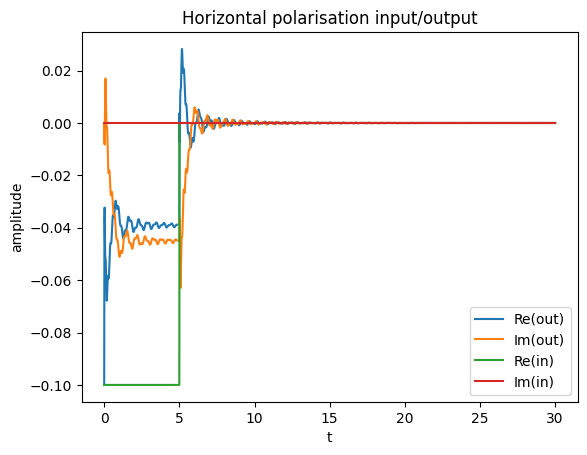

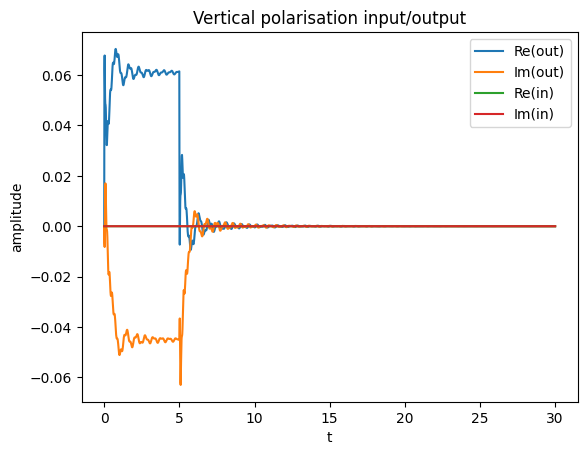

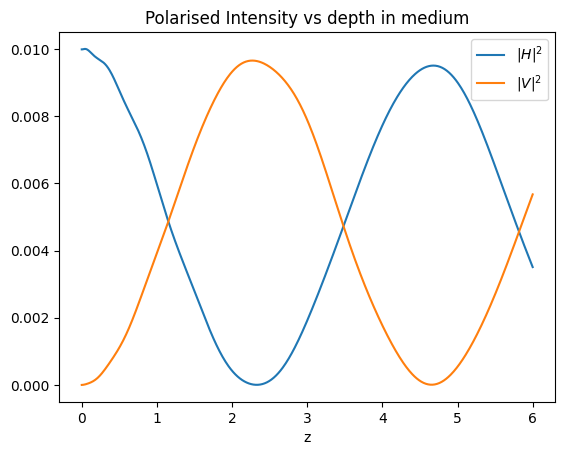

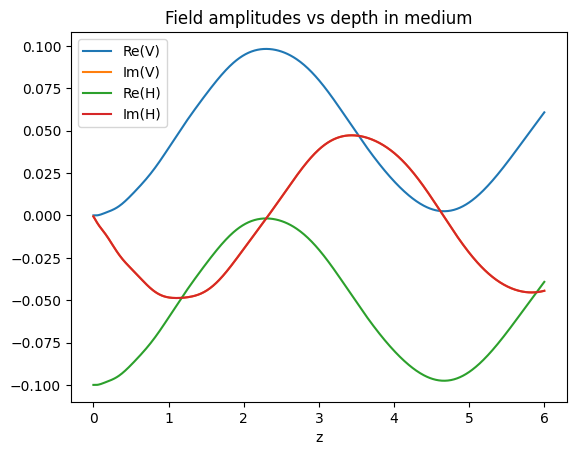

In [97]:
state = np.moveaxis(res, 0,-1) #Move the time axis to the end, so state axis is at the start 
                                #and we can use polF(*state)
pol_H = (pol_H_F(*state)*scaled_lineshape[..., newaxis]).sum(axis=deltaAxIndex) # This comes from calcPolFuncF
pol_V = (pol_V_F(*state)*scaled_lineshape[..., newaxis]).sum(axis=deltaAxIndex) # This comes from calcPolFuncF

Ein_H = sm.lambdify(tS, Ein_expr_H.subs(paramsD), 'numpy')(tSteps)
Ein_V = sm.lambdify(tS, Ein_expr_V.subs(paramsD), 'numpy')(tSteps)
Ein_V = zeros(tSteps.size) if np.size(Ein_V) == 1 else Ein_V # In case one direction is sympy collapses ths size
Ein_H = zeros(tSteps.size) if np.size(Ein_H) == 1 else Ein_H


#Eout_H = 1j*pol_H.cumsum(axis=0)  + Ein_H[newaxis] # Actual field is the sum of the input + atom polarisation
#Eout_V = 1j*pol_V.cumsum(axis=0)  + Ein_V[newaxis]

Eout_H = np.array([calc_H_polF(cur_state).squeeze() for cur_state in res]) + Ein_H[:,newaxis]
Eout_V = np.array([calc_V_polF(cur_state).squeeze() for cur_state in res]) + Ein_V[:,newaxis]
#Eout_H = np.array([calc_H_polF(cur_state) for cur_state in res ])  + Ein_H[newaxis] # Actual field is the sum of the input + atom polarisation
#Eout_H = 1j*pol_H.cumsum(axis=0)  + Ein_H[newaxis] # Actual field is the sum of the input + atom polarisation
#Eout_V = 1j*pol_V.cumsum(axis=0)  + Ein_V[newaxis]
plot(tSteps, Eout_H[:,-1].real, label='Re(out)')
plot(tSteps, Eout_H[:,-1].imag, label='Im(out)')
plot(tSteps, Ein_H.real, label='Re(in)')
plot(tSteps, Ein_H.imag, label='Im(in)')
legend()
xlabel('t')
ylabel('amplitude')
title("Horizontal polarisation input/output")

figure()
plot(tSteps, Eout_V[:,-1].real, label='Re(out)')
plot(tSteps, Eout_V[:,-1].imag, label='Im(out)')
plot(tSteps, Ein_V.real, label='Re(in)')
plot(tSteps, Ein_V.imag, label='Im(in)')
legend()
xlabel('t')
ylabel('amplitude')
title("Vertical polarisation input/output")

figure()
plot(zAx, np.abs(Eout_H[tSteps.size//8])**2, label = "$|H|^2$" )
plot(zAx, np.abs(Eout_V[tSteps.size//8])**2, label = "$|V|^2$")
xlabel("z")
title("Polarised Intensity vs depth in medium")
legend()

figure()
plot(zAx, Eout_V[tSteps.size//8].real, label="Re(V)")
plot(zAx, Eout_V[tSteps.size//8].imag, label="Im(V)")
plot(zAx, Eout_H[tSteps.size//8].real, label="Re(H)")
plot(zAx, Eout_H[tSteps.size//8].imag, label="Im(H)")
xlabel("z")
title("Field amplitudes vs depth in medium")
legend()